In [23]:
# Ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [24]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer, StandardScaler
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix, 
                             classification_report, f1_score, accuracy_score,
                             precision_recall_curve, PrecisionRecallDisplay,
                             roc_curve, RocCurveDisplay, auc)
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

from datassist import experiment
from datassist import log_results

In [25]:
df_titanic = pd.read_csv('data/train.csv')
df_titanic = df_titanic.set_index('PassengerId')

## Preprocessing Pipeline

In [26]:
params = {
    'random_state': 42,
    'imputer': 'median (pandas df.fillna())'
}

In [27]:
# Dropping Name since it is not important for prediction,
# Cabin is also not useful since it has too many missing values.
# Finally, ticket is a random string of characters
X = df_titanic.drop(columns=['Survived', 'Name', 'Cabin', 'Ticket'])
y = df_titanic['Survived']

In [28]:
# Impute missing values
X['Age'] = X['Age'].fillna(X['Age'].median())

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=params['random_state'])

In [30]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
299,1,male,28.00,0,0,30.5000,S
885,3,male,25.00,0,0,7.0500,S
248,2,female,24.00,0,2,14.5000,S
479,3,male,22.00,0,0,7.5208,S
306,1,male,0.92,1,2,151.5500,S


In [31]:
# class InputReshaper(BaseEstimator, TransformerMixin):
#     """Reshape the input to the imputer if 1D to get rid of error"""
#     def __init__(self, imputer) -> None:
#         super().__init__()
#         self.imputer = imputer

#     def fit(self, X, y=None):
#         if X.ndim == 1:
#             self.imputer.fit(X.to_numpy().reshape(-1, 1))
#         else:
#             self.imputer.fit(X)
#         return self
    
#     def transform(self, X, y=None):
#         if X.ndim == 1:
#             return self.imputer.transform(X.to_numpy().reshape(-1, 1))
#         else:
#             return self.imputer.transform(X)

In [32]:
# Feature Engineering
# imputer = InputReshaper(SimpleImputer(strategy=='median'))
# numeric_transformer = QuantileTransformer(
#     output_distribution='normal',
#     random_state=params['random_state'],
#     n_quantiles=500
# )
numeric_transformer = StandardScaler()
categorical_encoder = OneHotEncoder()

# Identify Features
numeric_features = X.drop(columns=['SibSp', 'Parch']).select_dtypes(include='number').columns
categorical_features = X.select_dtypes(include='object').columns

column_transformer = ColumnTransformer(
    [
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_encoder, categorical_features),
    ],
    # SibSp and ParCh will be passed through unchanged since
    # they are omitted from `numeric_features`
    remainder="passthrough",
    n_jobs=-1
)

In [33]:
clf = LinearSVC(random_state=params['random_state'])

pipe = Pipeline((
    ('preprocessing', column_transformer),
    ('classifier', clf)
))

## Results

In [34]:
# Evaluate using cross validation
cv_results = experiment.evaluate_cv(pipe, X_train, y_train, scoring='f1')
experiment.print_cv_results(cv_results, scoring='F1 score')

CV Results
F1 score: 0.72534 +/- 0.03410
training time: 0.03s +/- 0.00s


In [35]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)

c:\Users\Adam\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [36]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       134
           1       0.74      0.71      0.72        89

    accuracy                           0.78       223
   macro avg       0.78      0.77      0.77       223
weighted avg       0.78      0.78      0.78       223



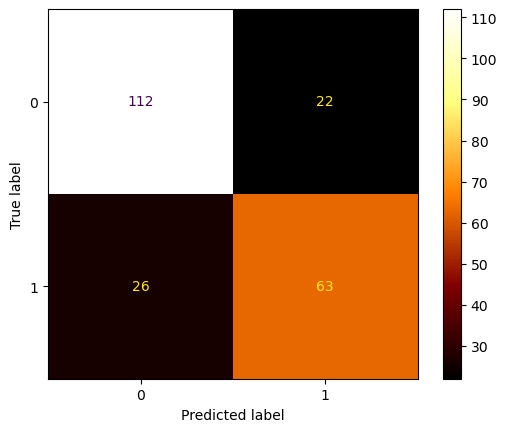

In [37]:
cm = confusion_matrix(y_val, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
cm_display.im_.set_cmap('afmhot')

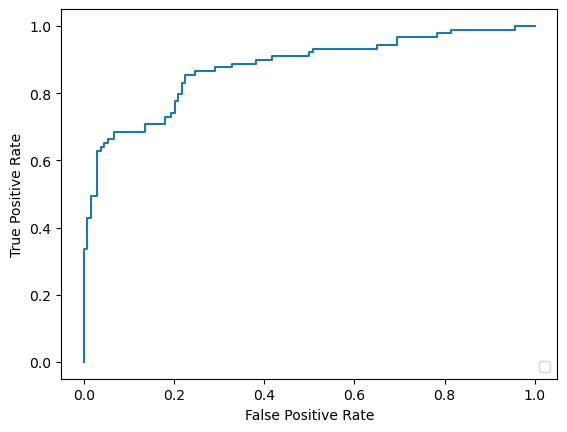

In [38]:
y_score = pipe.decision_function(X_val)

fpr, tpr, _ = roc_curve(y_val, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [39]:
auc(fpr, tpr)

0.8766560456146235

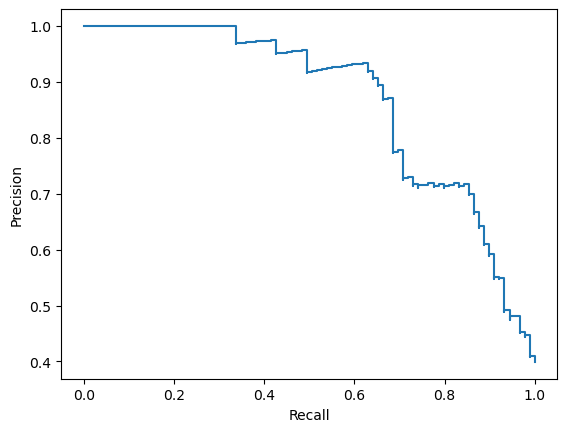

In [40]:
prec, recall, _ = precision_recall_curve(y_val, y_score, pos_label=clf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

## Log Results

In [41]:
metrics = {
    'F1_score': f1_score(y_val, y_pred),
    'AUC': auc(fpr, tpr),
    'Accuracy': accuracy_score(y_val, y_pred)
}

In [42]:
# Setup experiment logging
helper = log_results.MlflowHelper()
helper.start_local_tracking_server()
helper.setup_experiment('Titanic')

In [43]:
# Evaluate the model on the validation set
def log_model(
    model,
    params: dict | None,
    metrics: dict | None,
    tags: dict | None
):
    return model, params, metrics, tags

In [44]:
helper.run_experiment(
    lambda: log_model(pipe, params, metrics, None),
)

fluent 1
